In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('heart.csv')

### EDA

In [3]:
df.info()
#missing value는 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
#수치형 변수와 카테고리 변수 나누기
numerical = df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns
categorical = df.select_dtypes('object').columns

print('수치형 변수:', df[numerical].columns)
print('카테고리 변수:', df[categorical].columns)

수치형 변수: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')
카테고리 변수: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [6]:
#범주형 변수의 고유 값 개수 확인
df[categorical].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

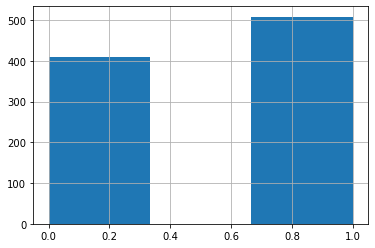

In [12]:
#타겟변수 분리 및 타겟변수의 비율 확인
y_target = df['HeartDisease']
df['HeartDisease'].hist(bins=3)

약간의 imbalance가 있지만 문제될 정도는 아니라 accuracy로 평가 가능한 데이터 세트

In [20]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [21]:
#수치형 변수의 왜도 측정
import plotly
from plotly.offline import iplot
df[numerical].iplot(kind='histogram', subplots=True, bins=50)

In [22]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness
skew_vals = df[numerical].drop('FastingBS', axis=1).skew()
skew_cols = skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending=False)
skew_cols

Oldpeak    1.022872
dtype: float64

In [23]:
skew_vals

Age           -0.195933
RestingBP      0.179839
Cholesterol   -0.610086
MaxHR         -0.144359
Oldpeak        1.022872
dtype: float64

skewness 임계값 0.75를 넘는건 Oldpeak밖에 없음

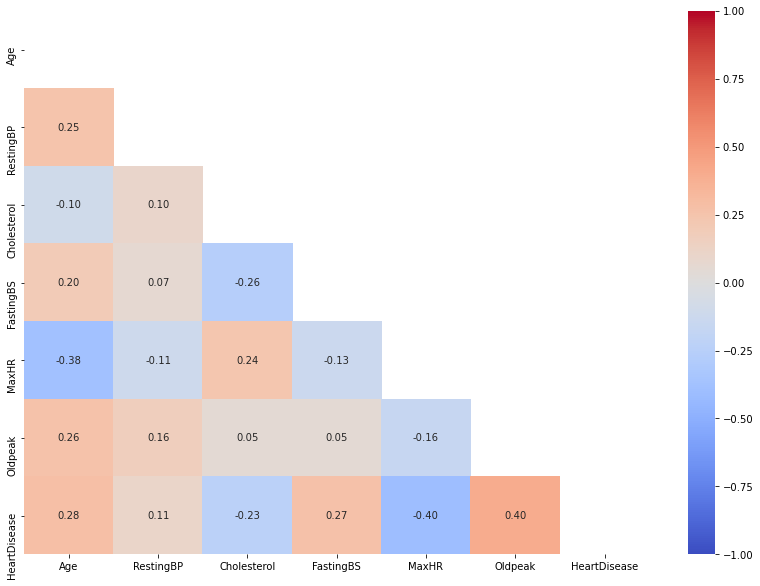

In [24]:
#target변수와의 상관관계
numerical1 = df.select_dtypes('number').columns
matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df[numerical1].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix, ax=ax)

타겟 변수와 피처들은 대부분 약한 상관관계를 보임

### Model Selection
- dummy classifier
- Logistic & Linear Discriminant & SVC & KNN (scaler 없이)
- Ensemble 모델(Adaboost, GradientBoost, RandomForest, ExtraTrees)
- 유명한 3인방(XGBoost, LGBM, Catboost)
- Catboost HyperParameter Tuning(OPTUNA로 튜닝)
- 피쳐 중요도
- 모델끼리 비교

In [27]:
#Baseline model (dummy classifier): 모델 성능 비교의 기준이 되는 모델, 모델 성능에 대한 최소 하한선
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,classification_report

X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder='passthrough')

model = DummyClassifier(strategy='constant', constant=1) #항상 상수 1로 예측해버리기
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
np.around(accuracy_score(y_test, y_pred),4)

0.5942

In [31]:
#Logistic & Linear Discriminant & SVC & KNN (스케일링 없이)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

accuracy = []
model_names = []

X = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder='passthrough')

lr = LogisticRegression(solver='liblinear')
lda = LinearDiscriminantAnalysis()
svc = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr, lda, svc, knn]
for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred)))
    print('모델:', model, '& accuracy score:', np.round(accuracy_score(y_test, y_pred),4))

모델: LogisticRegression(solver='liblinear') & accuracy score: 0.8841
모델: LinearDiscriminantAnalysis() & accuracy score: 0.8696
모델: SVC() & accuracy score: 0.7246
모델: KNeighborsClassifier() & accuracy score: 0.7174


In [33]:
#Logistic & Linear Discriminant & SVC & KNN (스케일링 有, 표준화 scaler)
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
ct_scale = make_column_transformer((ohe, categorical), (std_scaler, numerical))

lr = LogisticRegression(solver='liblinear')
lda = LinearDiscriminantAnalysis()
svc = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr, lda, svc, knn]
for model in models:
    pipe = make_pipeline(ct_scale, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred)))
    print('모델:', model, '& accuracy score:', np.round(accuracy_score(y_test, y_pred),4))

모델: LogisticRegression(solver='liblinear') & accuracy score: 0.8804
모델: LinearDiscriminantAnalysis() & accuracy score: 0.8696
모델: SVC() & accuracy score: 0.8841
모델: KNeighborsClassifier() & accuracy score: 0.8841


In [34]:
#앙상블 모델(Adaboost, Gradient Boosting, RandomForest, ExtraTrees)
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

ada = AdaBoostClassifier(random_state=123)
gb = GradientBoostingClassifier(random_state=123)
rf = RandomForestClassifier(random_state=123)
et = ExtraTreesClassifier(random_state=123)

models = [ada, gb, rf, et]
for model in models:
    pipe = make_pipeline(ct_scale, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred)))
    print('모델:', model, '& accuracy score:', np.round(accuracy_score(y_test, y_pred),4))

모델: AdaBoostClassifier(random_state=123) & accuracy score: 0.8659
모델: GradientBoostingClassifier(random_state=123) & accuracy score: 0.8732
모델: RandomForestClassifier(random_state=123) & accuracy score: 0.8804
모델: ExtraTreesClassifier(random_state=123) & accuracy score: 0.8732


In [38]:
#3형제 - XGBoost, LGBM, Catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

xgb = XGBClassifier(random_state=123)
lgbm = LGBMClassifier(random_staten=123)

models = [xgb, lgbm]
for model in models:
    pipe = make_pipeline(ct_scale, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred)))
    print('모델:', model, '& accuracy score:', np.round(accuracy_score(y_test, y_pred),4))

[23:19:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
모델: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) & accuracy score: 0.8297
[LightGBM] [Warning] Unknown parameter: random_staten
모델: LGBMClassifier(rand

In [44]:
#Catboost
from catboost import CatBoostClassifier
categorical_features_indices = np.where(X.dtypes != np.float)[0]
model = CatBoostClassifier(verbose=False, random_state=123)
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred)))

In [46]:
print('모델:', model, '& accuracy score:', np.round(accuracy_score(y_test, y_pred),4))

모델: <catboost.core.CatBoostClassifier object at 0x000001C2FAA4C280> & accuracy score: 0.8877


In [52]:
#Optuna를 통한 하이퍼파라미터 튜닝
import optuna

#trial : 조정해야하는 하이퍼파라미터를 지정하기 위해 objective 함수에 전달
def objective(trial):
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    categorical_features_indices = np.where(X.dtypes != np.float)[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
    #조정할 하이퍼 파라미터 정의
    param = {
        'objective':trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'depth':trial.suggest_int('depth', 1, 12),
        'boosting_type':trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type':trial.suggest_categorical('boostrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'used_ram_limit':'3gb'
    }
    
    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    cat_cls = CatBoostClassifier(**param)
    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features = categorical_features_indices,
               verbose=0, early_stopping_rounds=100)
    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

- trial.suggest_categorical(‘파라미터_이름’,[파라미터 값]) 
→ List 내의 데이터 중 선택
- trial.suggest_float/int(‘파라미터_이름’,범위)
→범위 내의 실수형/정수형 값 선택

In [53]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, timeout=600)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-04-02 23:54:07,336] A new study created in memory with name: no-name-c2d205d7-3279-4972-99d2-fc50c8cd02dc
[I 2022-04-02 23:54:15,912] Trial 0 finished with value: 0.8623188405797102 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0346760886780441, 'depth': 5, 'boosting_type': 'Ordered', 'boostrap_type': 'Bernoulli', 'subsample': 0.2616489408159326}. Best is trial 0 with value: 0.8623188405797102.
[I 2022-04-02 23:54:28,406] Trial 1 finished with value: 0.8659420289855072 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07630135088959546, 'depth': 8, 'boosting_type': 'Ordered', 'boostrap_type': 'Bayesian', 'bagging_temperature': 3.4593598971311246}. Best is trial 1 with value: 0.8659420289855072.
[I 2022-04-02 23:55:02,383] Trial 2 finished with value: 0.8768115942028986 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09934996689265457, 'depth': 12, 'boosting_type': 'Ordered', 'boostrap_type': 'Bernoulli', 'subsample': 0.710870

[I 2022-04-03 00:02:24,759] Trial 25 finished with value: 0.8695652173913043 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07020688576688272, 'depth': 9, 'boosting_type': 'Ordered', 'boostrap_type': 'Bernoulli', 'subsample': 0.8380085280662835}. Best is trial 13 with value: 0.8804347826086957.
[I 2022-04-03 00:02:52,173] Trial 26 finished with value: 0.8731884057971014 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08292346756173483, 'depth': 11, 'boosting_type': 'Plain', 'boostrap_type': 'Bernoulli', 'subsample': 0.5520634579728424}. Best is trial 13 with value: 0.8804347826086957.
[I 2022-04-03 00:03:07,317] Trial 27 finished with value: 0.8695652173913043 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06905448511930794, 'depth': 7, 'boosting_type': 'Plain', 'boostrap_type': 'Bernoulli', 'subsample': 0.9513193491847475}. Best is trial 13 with value: 0.8804347826086957.
[I 2022-04-03 00:03:41,439] Trial 28 finished wit

Number of finished trials: 31
Best trial:
  Value: 0.8804347826086957
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.08180988269640362
    depth: 9
    boosting_type: Ordered
    boostrap_type: Bernoulli
    subsample: 0.6713525455264852


optuna 적용
- 최적화할 함수: objective
- direction: score값을 최대(‘maximize‘)또는
최소(‘minimize’)로하는 방향으로 지정
- n_trials: 시도 횟수

In [55]:
import plotly.express as px
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()